# Analysis of Cancer Gene Expression Data

##### Python main module imports for data analysis

The purpose of this analysis is to implement elastic net regularization on logistic regression to perform feature selection and classication tasks on genetic data

In [50]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.stats import norm


# Math
import math

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Preprocessing Imports
from sklearn.preprocessing import normalize

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluating our ML results
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

# For Spectral Clustering algorithms
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

# network imports
import networkx as nx
import igraph as ig

### Data Cleaning

##### Choose the data set:

In [51]:
# read data file
datafile = '~/Documents/THESIS/project/ICOS_DATA/breast_preprocessed.txt'
data = pd.read_table(datafile, delim_whitespace = True, 
                     dtype={'a': np.float64}, header = None)

In [52]:
# data dimension
print data.shape
# last 5 rows of the data
data.tail()

(47294, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
47289,lysA,5.68,5.7194,5.7592,5.6898,5.7236,5.662,5.6684,5.6742,5.6669,...,5.7164,5.7175,5.7133,5.7133,5.6753,5.6679,5.6692,5.7666,5.72,5.75
47290,pheA,5.705,5.6142,5.6955,5.6227,5.6727,5.5995,5.633,5.6539,5.6511,...,5.6595,5.6292,5.6042,5.6266,5.6022,5.6709,5.6136,5.6038,5.6693,5.5818
47291,thrB,5.7077,5.7586,5.7279,5.6777,5.6761,5.7091,5.6777,5.68,5.6763,...,5.6918,5.6501,5.5772,5.6637,5.6556,5.6587,5.6987,5.6933,5.6775,5.68
47292,trpF,5.6684,5.6585,5.6337,5.6427,5.6371,5.6691,5.62,5.6199,5.6608,...,5.6392,5.6451,5.6149,5.551,5.605,5.6246,5.5404,5.6206,5.6552,5.6141
47293,y,luminal,luminal,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,...,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,luminal,non-luminal,luminal


In [53]:
# extract colum names (all but last one are gene names).
colNames = data[0]
colNames = list(colNames)

In [54]:
# tranpose the data to have genes as columns and microarray experiment as rows
data2 = data.T.ix[1:]

# reset the index to satrt at 0
data2 = data2.reset_index(drop=True)

# add colum labels
data2.columns=colNames
data2.head()

,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF,y
0,5.3416,5.846,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.5959,5.8873,5.8005,5.5931,5.746,5.68,5.705,5.7077,5.6684,luminal
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585,luminal
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337,luminal
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427,luminal
4,5.5385,5.8876,6.572,6.1651,8.8246,5.7474,5.821,7.4015,5.6479,5.8412,...,5.7101,5.8066,5.6583,5.7032,5.58,5.7236,5.6727,5.6761,5.6371,luminal


In [55]:
data2.describe()

,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF,y
count,128.0000,128.0000,128.0000,128.0000,128.000,128.0000,128.0000,128.0000,128.0000,128.0000,...,128,128,128,128,128,128,128,128,128,128
unique,127.0000,125.0000,124.0000,127.0000,126.000,125.0000,127.0000,126.0000,127.0000,127.0000,...,126,128,127,125,126,121,121,121,123,2
top,5.5094,5.8394,6.7812,5.9103,8.632,5.8066,5.8408,7.5101,5.3875,5.7857,...,5.7259,5.6567,6.1477,5.8009,5.4501,5.7032,5.6022,5.6775,5.63,luminal
freq,2.0000,2.0000,2.0000,2.0000,2.000,2.0000,2.0000,2.0000,2.0000,2.0000,...,2,1,2,2,2,2,2,3,2,84


In [56]:
# create date set with genes only. This is the features matrix
X = data2[range(data.shape[0]-1)]
print X.shape

# make sure data type is float and not string.
X = X.astype(float)

(128, 47293)


In [57]:
# store the gene names/ids
geneNames = X.columns

In [58]:
X.head()

,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9715-S,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF
0,5.3416,5.8460,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.7645,5.5959,5.8873,5.8005,5.5931,5.7460,5.6800,5.7050,5.7077,5.6684
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.8293,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.6392,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.7021,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427
4,5.5385,5.8876,6.5720,6.1651,8.8246,5.7474,5.8210,7.4015,5.6479,5.8412,...,5.8150,5.7101,5.8066,5.6583,5.7032,5.5800,5.7236,5.6727,5.6761,5.6371


In [59]:
# create vector with response variable
Y = data2[[-1]]
Y.head().dtypes

y    object
dtype: object

In [60]:
# make sure response vector is binary 0, 1.
Y = pd.get_dummies(Y)
Y.head(6)

,y_luminal,y_non-luminal
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1


In [61]:
# choose one of the equivalent response vectors.
Y = Y.ix[:,0]

In [62]:
#Percent of cancer positive
np.mean(Y)

0.65625

In [63]:
np.std(np.ravel(X))

0.82144745622309201

In [64]:
#Y = np.ravel(Y)

## Classification with Penalized Logistic Model

### The Sigmoid

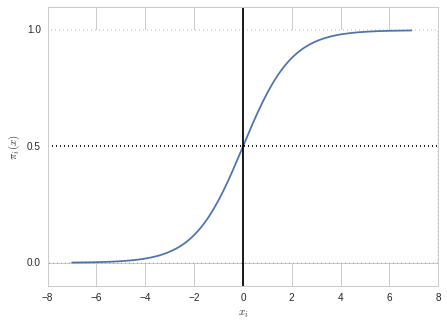

In [65]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.figure(figsize=(7,5))
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.axhspan(0.0, 1.0, facecolor='1.0', alpha=1.0, ls='dotted')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.yticks([0.0, 0.5, 1.0])
plt.ylim(-0.1, 1.1)
plt.xlabel('$x_i$')
plt.ylabel('$\pi_i (x)$')
plt.savefig('sigmoid')
plt.show()

In [66]:
# model definition
# logistic regression with elasticnet regularization
# l1_ratio refers to alpha and alpha refers to lamba in Hastie
log_model = SGDClassifier(loss = 'log', penalty = 'elasticnet', alpha = 0.175, 
                                l1_ratio = 0.5, fit_intercept = True)

### Significant Gene Selection Cross-Validation

In [67]:
#initialize the dataframes for ranking genes
selected_genes = {'col1':'gene1'}
gene_names = DataFrame(geneNames)
gene_names.columns = ['trial0']

# Initial trial column 
gene_select_count = gene_names.isin(selected_genes)
gene_coeff = DataFrame()

# Number of trials
M = 400

# IN THE LOOP
for i in range(M):
    # Split the data

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


    # Fit model and select significant genes

    fit_log_model = log_model.fit(X_train, Y_train)
    X_selected = fit_log_model.transform(X_test)


    # Find the indexes of significant genes

    # these are the index of the features selected by the l1 regularized logistic model
    selected_index = np.where(log_model.coef_!=0)[-1]
    # Selected genes in ith trial
    selected_genes = gene_names.loc[selected_index]

    gene_select_count['trial' + str(i)] = gene_names.isin(selected_genes)
    gene_coeff['trial' + str(i)] = Series(log_model.coef_[0])
    

In [68]:
beta_coeff = gene_coeff.mean(axis = 1)
beta_sterror = gene_coeff.std(axis = 1)
gene_imp_score = gene_coeff.mean(axis = 1).abs()
pvalue = 1-norm.cdf(np.abs(beta_coeff/beta_sterror))

In [69]:
# this creates a pandas Series with the sum of how many times a gene was selected
gene_select_summary = gene_select_count.sum(axis = 1)

In [70]:
# this data frame has the values for all genes
result = DataFrame([geneNames, gene_select_summary, gene_imp_score, beta_coeff, beta_sterror, pvalue], index = 
          ['Gene', 'Frequency', 'Score', 'Coefficient', 'Std Error', 'pvalue']).T.sort(['Frequency', 'Score'], 
                                                            ascending = False)

In [71]:
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head()

,Gene,Frequency,Coefficient,Std Error,pvalue
22089,GI_4503602-S,400,3.073594,0.7283768,1.222673e-05
5644,GI_21614543-S,400,-2.002927,0.5968818,0.000395892
17275,GI_38455428-S,400,1.96534,0.6581828,0.001413219
22149,GI_4503928-S,400,1.580763,0.5672953,0.002664108
10064,GI_29738585-S,400,1.461232,0.4833238,0.001250181


In [72]:
GI_4503602_S = X['GI_4503602-S']
GI_21614543_S = X['GI_21614543-S']

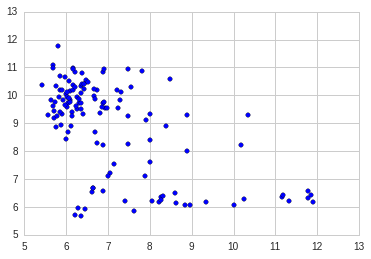

In [73]:
#plt.scatter(range(128),GI_4503602_S)
plt.scatter(GI_21614543_S,GI_4503602_S)
plt.show()

In [74]:
#correlation
submat = X[['GI_4503602-S','GI_38455428-S','GI_29738585-S','GI_21614543-S','GI_9951924-S']].T

np.corrcoef(submat)

array([[ 1.        ,  0.80972455,  0.73625334, -0.59823435,  0.83457833],
       [ 0.80972455,  1.        ,  0.64928769, -0.54427371,  0.74263589],
       [ 0.73625334,  0.64928769,  1.        , -0.569731  ,  0.69178296],
       [-0.59823435, -0.54427371, -0.569731  ,  1.        , -0.5111184 ],
       [ 0.83457833,  0.74263589,  0.69178296, -0.5111184 ,  1.        ]])

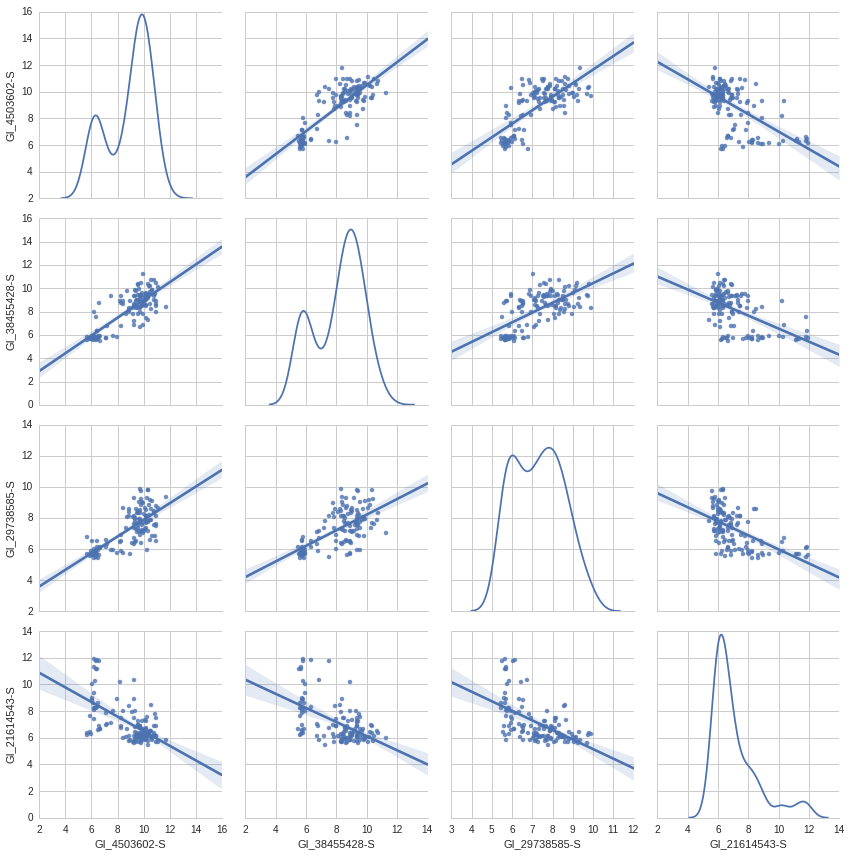

In [75]:
submat = X[['GI_4503602-S','GI_38455428-S','GI_29738585-S','GI_21614543-S']]

sns_plot = sns.pairplot(submat,kind='reg',diag_kind='kde')
sns_plot.savefig("snscorr.png")

In [76]:
# this gives the indices of selected genes according to some threshold. can use the importance score
# or the number of times selected.
selected_genes_index = gene_select_summary[gene_imp_score >= 0.0001].index

In [77]:
result = DataFrame([geneNames[selected_genes_index], gene_select_summary[selected_genes_index], 
           gene_imp_score[selected_genes_index], beta_coeff[selected_genes_index], beta_sterror[selected_genes_index],
           pvalue[selected_genes_index]], index = ['Gene', 'Frequency', 'Score','Coefficient', 'Std Error', 
                                                   'pvalue']).T.sort(['Frequency', 'Score'], 
                                                                     ascending = False)

In [78]:
print len(selected_genes_index)

1635


In [79]:
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']]

,Gene,Frequency,Coefficient,Std Error,pvalue
1212,GI_4503602-S,400,3.073594,0.7283768,1.222673e-05
406,GI_21614543-S,400,-2.002927,0.5968818,0.000395892
1000,GI_38455428-S,400,1.96534,0.6581828,0.001413219
1220,GI_4503928-S,400,1.580763,0.5672953,0.002664108
649,GI_29738585-S,400,1.461232,0.4833238,0.001250181
1576,GI_9951924-S,399,1.618243,0.5628423,0.00201933
691,GI_31341936-S,399,1.348721,0.5547718,0.007525961
1140,GI_42659459-S,399,1.328747,0.5693807,0.009806489
1237,GI_4504700-S,398,-0.9983627,0.4052952,0.006883279
710,GI_31542212-S,395,-1.209061,0.5445656,0.01320158


In [80]:
# these are the names of the selected genes
DataFrame(geneNames[selected_genes_index], columns = ['Selected Genes'], index = selected_genes_index).head()
len(DataFrame(geneNames[selected_genes_index], columns = ['Selected Genes'], index = selected_genes_index))

1635

In [81]:
#Need to create X_sel

X_sel = X[selected_genes_index]

X_sel.shape

(128, 1635)

In [82]:
# this gives the model's score
log_model.fit(X_sel,Y)
print log_model.score(X_sel,Y)

0.8984375


In [83]:
class_prob = log_model.predict_proba(X_sel)

In [84]:
class_prob.shape

(128, 2)

In [85]:
dfprob = DataFrame(class_prob)
print dfprob.mean()

0    0.273437
1    0.726563
dtype: float64


### Cross Validation

In [139]:
# Make a new log_model
#log_model2 = LogisticRegression()
log_model2 = LogisticRegression(dual = False, fit_intercept = True)

xvalacc = []
xvalROC = []
M = 100

for i in range(M):

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_sel, Y)

    # Now fit the new model
    log_model2.fit(X_train, Y_train)

    # Predict the classes of the testing data set
    class_predict = log_model2.predict(X_test)

    # Compare the predicted classes to the actual test classes
    xvalacc.append(metrics.accuracy_score(Y_test,class_predict))
    try:
        xvalROC.append(roc_auc_score(Y_test,class_predict))
    except ValueError:
        pass

In [140]:
np.std(xvalacc)

0.052585495861501595

In [141]:
np.mean(xvalacc)

0.86812500000000004

In [142]:
np.std(xvalROC)

0.062132810462303657

In [143]:
np.mean(xvalROC)

0.84261146077472138

In [144]:
class_predict

array([ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.])

In [145]:
roc_auc_score(Y_test,class_predict)

0.84412955465587047

In [146]:
confusion_matrix(Y_test,class_predict)

array([[11,  2],
       [ 3, 16]])

In [147]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test,class_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)

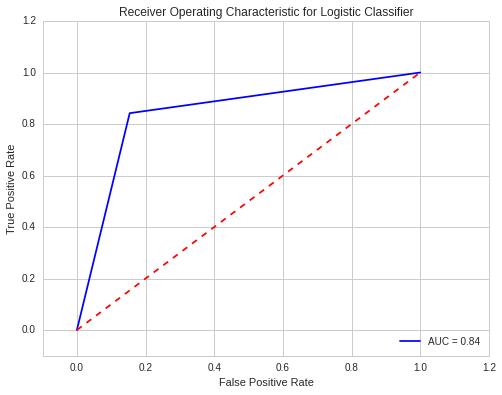

In [149]:
plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic for Logistic Classifier')
plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc) #roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('roc.png')
plt.show()

In [96]:
np.corrcoef(X_sel)

array([[ 1.        ,  0.82463071,  0.80116816, ...,  0.68569935,
         0.61969134,  0.72109683],
       [ 0.82463071,  1.        ,  0.86963994, ...,  0.67153189,
         0.67910512,  0.80953069],
       [ 0.80116816,  0.86963994,  1.        , ...,  0.65910091,
         0.68548216,  0.8514004 ],
       ..., 
       [ 0.68569935,  0.67153189,  0.65910091, ...,  1.        ,
         0.7615854 ,  0.70160083],
       [ 0.61969134,  0.67910512,  0.68548216, ...,  0.7615854 ,
         1.        ,  0.66404635],
       [ 0.72109683,  0.80953069,  0.8514004 , ...,  0.70160083,
         0.66404635,  1.        ]])

In [97]:
np.min(np.min(X))

4.9282000000000004

In [98]:
np.min(np.max(X))

5.4221000000000004